In [1]:
import os
import random
from collections import Counter
import logging.config
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import wandb
from dotenv import load_dotenv
load_dotenv()

# save weights and biases api key to .env file in project directory
assert os.getenv('WANDB_API_KEY')
assert torch.cuda.is_available()

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)


logging.config.fileConfig(
    os.path.join(os.getcwd(), '/code/source/config/logging.conf'),
    # defaults={'logfilename': os.path.join(os.getcwd(), 'tests/test_files/log.log')},
    disable_existing_loggers=False,
)


In [2]:
wandb.login()
wandb.init(project="MNIST-example")

2023-12-28 02:31:13 - ERROR    | Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shane-kercheval. Use `wandb login --relogin` to force relogin


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Running on CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Running on MPS GPU")
else:
    device = torch.device('cpu')
    print("Running on CPU")

Running on CUDA GPU


In [4]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.values
y = y.astype(int).values

<Axes: >

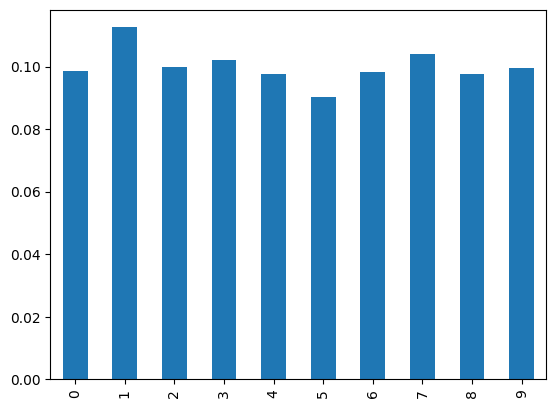

In [5]:
counter = Counter()
counter.update(y)
# e.g. 5 is slightly underrepresented
pd.DataFrame(sorted({item: count / len(y) for item, count in counter.items()}.items()))[1].plot.bar()

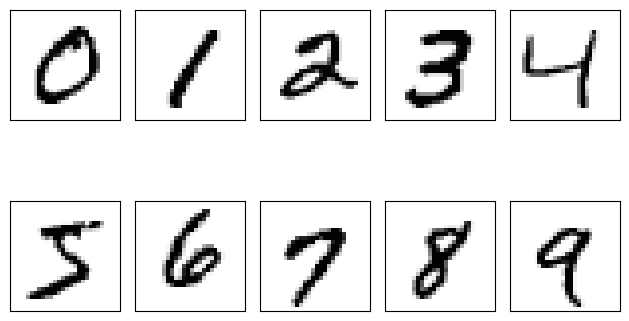

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [8]:
from sklearn.model_selection import train_test_split

# 80% train; 10% validation; 10% test
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"Training set  : X-{X_train.shape}, y-{y_train.shape}")
# print(f"Validation set: X-{X_val.shape}, y-{y_val.shape}")
print(f"Test set      : X-{X_test.shape}, y-{y_test.shape}")

Training set  : X-torch.Size([63000, 784]), y-torch.Size([63000])
Test set      : X-torch.Size([7000, 784]), y-torch.Size([7000])


In [9]:
from source.domain.pytorch_wrappers import FullyConnectedNN, PyTorchTrainer

model = FullyConnectedNN(
    input_size=28*28,
    hidden_layers=[500, 100],
    output_size=10,
)

print(f"# of parameters: {sum(param.numel() for param in model.parameters()):,}")
model

# of parameters: 443,610


FullyConnectedNN(
  (layers): ModuleList(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [10]:
trainer = PyTorchTrainer(
    model=model,
    loss_func=torch.nn.CrossEntropyLoss(),
    device=device,
    verbose=True,
    early_stopping_patience=2,
    validation_size=0.1,
)

In [11]:
training_loss, validation_loss = trainer.train(
    x=X_train,
    y=y_train,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
    batch_size=2**6,
    epochs=15,
    log_batches=20,
)

2023-12-28 02:31:22 - INFO     | Epoch 0 - Batch 0/886: Training Loss=2.328; Validation Loss=2.278
2023-12-28 02:31:22 - INFO     | Epoch 0 - Batch 44/886: Training Loss=1.192; Validation Loss=0.589
2023-12-28 02:31:23 - INFO     | Epoch 0 - Batch 88/886: Training Loss=0.498; Validation Loss=0.479
2023-12-28 02:31:23 - INFO     | Epoch 0 - Batch 132/886: Training Loss=0.454; Validation Loss=0.401
2023-12-28 02:31:23 - INFO     | Epoch 0 - Batch 176/886: Training Loss=0.402; Validation Loss=0.364
2023-12-28 02:31:23 - INFO     | Epoch 0 - Batch 220/886: Training Loss=0.385; Validation Loss=0.352
2023-12-28 02:31:23 - INFO     | Epoch 0 - Batch 264/886: Training Loss=0.316; Validation Loss=0.338
2023-12-28 02:31:23 - INFO     | Epoch 0 - Batch 308/886: Training Loss=0.304; Validation Loss=0.306
2023-12-28 02:31:24 - INFO     | Epoch 0 - Batch 352/886: Training Loss=0.279; Validation Loss=0.308
2023-12-28 02:31:24 - INFO     | Epoch 0 - Batch 396/886: Training Loss=0.280; Validation Loss=

In [12]:
trainer.early_stopping.lowest_loss

0.09944621304552706

In [13]:
print(training_loss)
print(validation_loss)

[0.16337617165933, 0.10481236591225579, 0.08289259804330595, 0.08147301234791098, 0.055926004295258715, 0.04798661028687075, 0.03933886027288815, 0.03559026097885384, 0.04094121631044349, 0.03157497868792694]
[0.18625703249185804, 0.13998497045229352, 0.11965033833942716, 0.12469948397742378, 0.10782859480333706, 0.11113820854633573, 0.09949679189494678, 0.09944621304552706, 0.1106538774838878, 0.11865160045287912]


In [14]:
trainer.best_validation_loss

0.09944621304552706

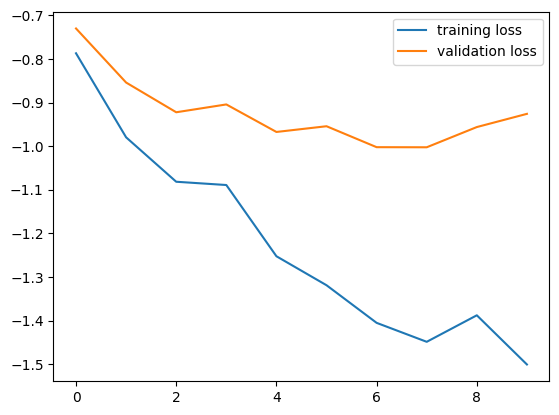

In [15]:
# plot training and validation losses
plt.plot(np.log10(training_loss), label='training loss')
plt.plot(np.log10(validation_loss), label='validation loss')
plt.legend()
plt.show()

In [37]:
training_loss_2, validation_loss_2 = trainer.train(
    x=X_train,
    y=y_train,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
    batch_size=2**6,
    epochs=15,
    log_batches=20,
)
training_loss += training_loss_2
validation_loss += validation_loss_2

2023-12-28 02:37:17 - INFO     | Epoch 0 - Batch 0/886: Training Loss=0.058; Validation Loss=0.117
2023-12-28 02:37:17 - INFO     | Epoch 0 - Batch 44/886: Training Loss=0.017; Validation Loss=0.105
2023-12-28 02:37:18 - INFO     | Epoch 0 - Batch 88/886: Training Loss=0.019; Validation Loss=0.101
2023-12-28 02:37:18 - INFO     | Epoch 0 - Batch 132/886: Training Loss=0.018; Validation Loss=0.096
2023-12-28 02:37:18 - INFO     | Epoch 0 - Batch 176/886: Training Loss=0.015; Validation Loss=0.096
2023-12-28 02:37:18 - INFO     | Epoch 0 - Batch 220/886: Training Loss=0.016; Validation Loss=0.093
2023-12-28 02:37:18 - INFO     | Epoch 0 - Batch 264/886: Training Loss=0.013; Validation Loss=0.093
2023-12-28 02:37:19 - INFO     | Epoch 0 - Batch 308/886: Training Loss=0.013; Validation Loss=0.092
2023-12-28 02:37:19 - INFO     | Epoch 0 - Batch 352/886: Training Loss=0.009; Validation Loss=0.094
2023-12-28 02:37:19 - INFO     | Epoch 0 - Batch 396/886: Training Loss=0.010; Validation Loss=

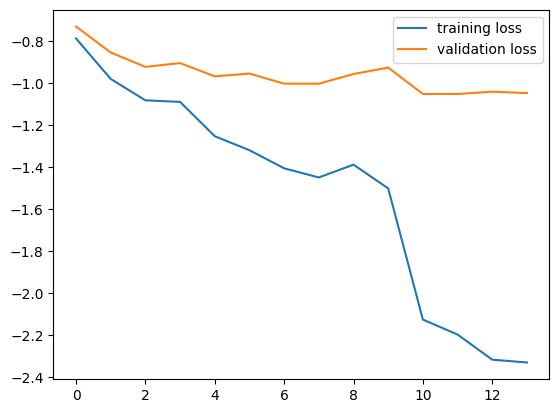

In [39]:
# plot training and validation losses
plt.plot(np.log10(training_loss), label='training loss')
plt.plot(np.log10(validation_loss), label='validation loss')
plt.legend()
plt.show()

---

In [40]:
predictions = trainer.predict(X_test)
predictions = torch.argmax(predictions.data, dim=1).cpu().numpy()
actual = y_test.cpu().numpy()
print(predictions[0:10])
print(actual[0:10])

[8 4 8 7 7 0 6 2 7 4]
[8 4 8 7 7 0 6 2 7 4]


In [41]:
from torch.utils.data import DataLoader, TensorDataset
from source.domain.pytorch_wrappers import calculate_average_loss

# test loss on the test set; do it in batches to avoid memory issues
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=10000, shuffle=False)
average_test_loss = calculate_average_loss(
    data_loader=DataLoader(TensorDataset(X_test, y_test), batch_size=10000, shuffle=False),
    model=model,
    loss_func=torch.nn.CrossEntropyLoss(),
    device=device,
)
print(f'avg test loss: {average_test_loss:.3f}')

avg test loss: 0.074


---

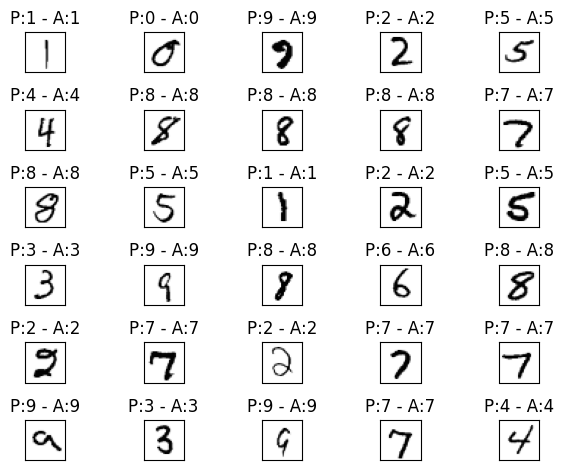

In [42]:
# plot the first 10 test images with their predicted labels
def plot_predictions(num_images: int = 10):
    fig, ax = plt.subplots(nrows=num_images // 5, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    rows = np.random.choice(X_test.shape[0], size=num_images, replace=False)
    for i, row in enumerate(rows):
        img = X_test[row].cpu().numpy().reshape(28, 28)
        ax[i].imshow(img, cmap='Greys')
        title_color = 'red' if predictions[row] != actual[row] else 'black'
        ax[i].set_title(f'P:{predictions[row]} - A:{actual[row]}', color=title_color)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

plot_predictions(num_images=30)

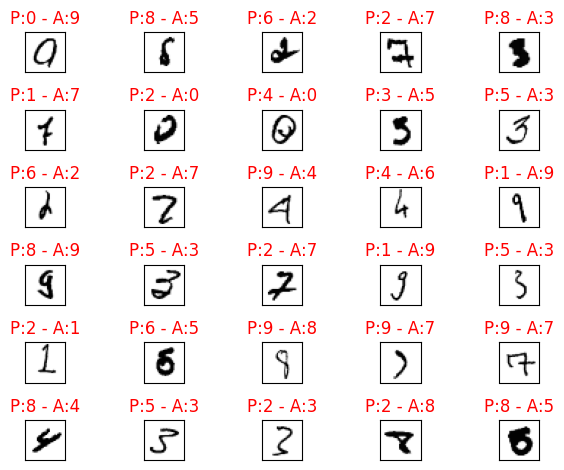

In [43]:
# plot the first 10 test images with their predicted labels
def plot_predictions(num_images: int = 10):
    fig, ax = plt.subplots(nrows=num_images // 5, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    mismatched_indexes = np.where(predictions != actual)[0]
    rows = np.random.choice(mismatched_indexes, size=num_images, replace=False)
    # rows = np.random.choice(X_test.shape[0], size=num_images, replace=False)
    for i, row in enumerate(rows):
        img = X_test[row].cpu().numpy().reshape(28, 28)
        ax[i].imshow(img, cmap='Greys')
        title_color = 'red' if predictions[row] != y_test[row] else 'black'
        ax[i].set_title(f'P:{predictions[row]} - A:{y_test[row]}', color=title_color)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

plot_predictions(num_images=30)

In [44]:
# calculate accuracy metrics on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

print(f'Accuracy: {accuracy_score(y_test, predictions):.3f}')
print(f'Precision: {precision_score(y_test, predictions, average="macro"):.3f}')
print(f'Recall: {recall_score(y_test, predictions, average="macro"):.3f}')
print(f'F1: {f1_score(y_test, predictions, average="macro"):.3f}')
print('---')
print(f'Accuracy: {accuracy_score(y_test, predictions):.3f}')
print(f'Precision: {precision_score(y_test, predictions, average="weighted"):.3f}')
print(f'Recall: {recall_score(y_test, predictions, average="weighted"):.3f}')
print(f'F1: {f1_score(y_test, predictions, average="weighted"):.3f}')
print('---')

Accuracy: 0.982
Precision: 0.981
Recall: 0.982
F1: 0.981
---
Accuracy: 0.982
Precision: 0.982
Recall: 0.982
F1: 0.982
---


In [45]:
((y_test == 3)& (predictions == 3)).sum().item()

742

In [46]:
# manually calcualte recall for class 3
_class = 8
true_positives = ((y_test == _class) & (predictions == _class)).sum().item()
false_negatives = ((y_test == _class) & (predictions != _class)).sum().item()
print(f'Recall for class {_class}: {true_positives / (true_positives + false_negatives):.3f}')

Recall for class 8: 0.981


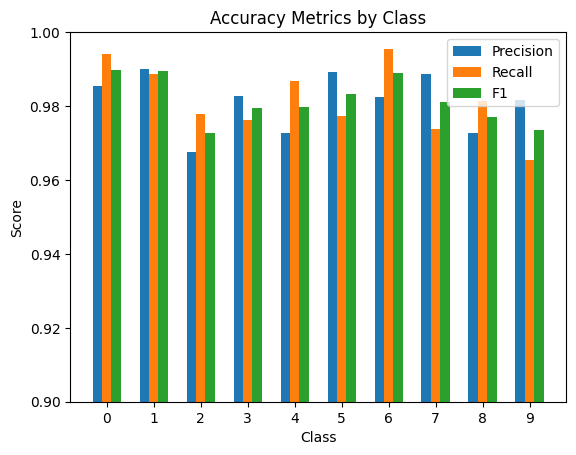

In [47]:
import matplotlib.pyplot as plt

# for each class calculate the accuracy metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions)

# create a bar plot
x = range(10)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x, precision, width, label='Precision')
rects2 = ax.bar([i + width for i in x], recall, width, label='Recall')
rects3 = ax.bar([i + 2 * width for i in x], f1, width, label='F1')

# add labels, title, and legend
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Accuracy Metrics by Class')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(range(10))
ax.legend()
# only show y ragen from 0.7 to 1.0
ax.set_ylim([0.9, 1.0])

# display the plot
plt.show()

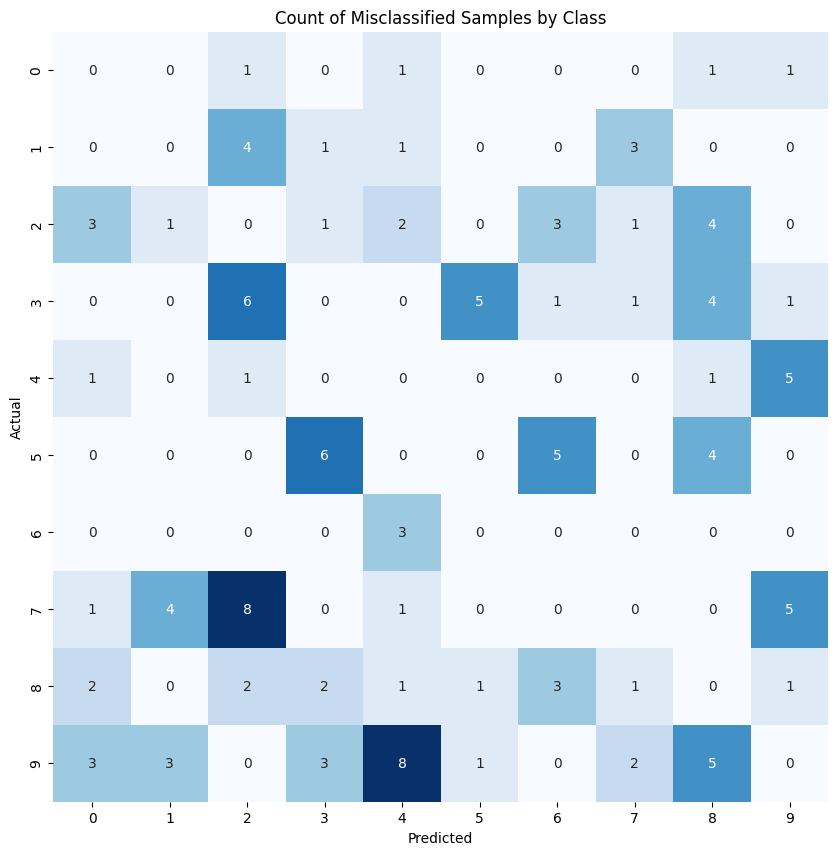

In [48]:
# create a heatmap of misclassified samples
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
# remove the diagonal values for better visualization
np.fill_diagonal(cm, 0)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Count of Misclassified Samples by Class')
plt.show()

---